# Computational Linear Algebra: Homework 3


**Academic Year:** 2025/2026

### Team Members:
1. Indiano, Giovanni (357942);
2. Stradiotti, Fabio (359415).

## 0. Import and Helper Functions

In [11]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as splinalg
import matplotlib.pyplot as plt

In [12]:
def read_dat(file_name):
    """
    Reads a graph from a .dat file and constructs the column-stochastic link matrix A.
    Returns:
        A (scipy.sparse.csc_matrix): The link matrix.
        labels (dict): A mapping from node ID to node name.
    """
    labels = {}
    row_indices = [] # Lists to store sparse matrix coordinates
    col_indices = []
    
    try:
        with open(file_name, 'r') as file:
            first_line = file.readline().strip()
            if not first_line:
                 return None, None
            parts = first_line.split()
            num_nodes = int(parts[0])
            num_edges = int(parts[1])
            
            # Use COO format for construction (efficient for appending)
            # Later convert to CSC (Compressed Sparse Column) for calculation
            
            for _ in range(num_nodes):
                line = file.readline().strip()
                if line:
                    parts = line.split(maxsplit=1) 
                    node_id = int(parts[0])
                    node_name = parts[1]
                    labels[node_id] = node_name

            for _ in range(num_edges):
                line = file.readline().strip()
                if line:
                    parts = line.split()
                    source = int(parts[0])
                    target = int(parts[1])
                    # Store coordinates instead of filling dense matrix directly
                    # A[target-1][source-1]=1
                    row_indices.append(target - 1)
                    col_indices.append(source - 1)
            
            # Create sparse matrix with 1s at specific coordinates
            data = np.ones(len(row_indices))
            A = sparse.coo_matrix((data, (row_indices, col_indices)), shape=(num_nodes, num_nodes)).tocsc()
            
            # Efficient column normalization for sparse matrix
            # Calculate sum of each column
            col_sums = np.array(A.sum(axis=0)).flatten()
            
            # Avoid division by zero. If sum is 0, scaling factor is 0.
            # This leaves the column as a zero vector in A, which is correct because 
            # we handle the dangling mass explicitly in the power_iteration function
            with np.errstate(divide='ignore', invalid='ignore'):
                scale_factors = np.where(col_sums != 0, 1.0 / col_sums, 0)
            
            # Multiply A by diagonal matrix of inverse sums to normalize
            D_inv = sparse.diags(scale_factors)
            A = A @ D_inv
                    
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found.")
        return None, None
    except Exception as e:
        print(f"Error during the analysis of the file: {e}")
        return None, None
    
    return A, labels

def power_iteration_with_vector(A, s, m, tolerance=1e-6, max_iterations=1000):
    """
    Computes the PageRank vector using the Power Iteration method.
    Args:
        A: The column-stochastic link matrix (sparse).
        s: The personalization vector (usually uniform 1/n).
        m: The damping factor (probability of random jump).
    """
    n = A.shape[0]
    x = np.ones(n) / n # initial vector (normalized)
    
    # Identify dangling nodes indices (columns that sum to zero)
    col_sums = np.array(A.sum(axis=0)).flatten()
    dangling_indices = np.where(col_sums == 0)[0]
    
    for iteration in range(max_iterations):
        # 1. Compute contribution from existing links
        # Mass from dangling nodes is lost here because their columns are 0
        Ax = A @ x
        
        # Compute contribution from dangling nodes
        dangling_contribution = np.sum(x[dangling_indices])
        
        # Apply the Google PageRank formula with dangling node mass redistribution
        x_new = (1 - m) * Ax + (1-m)* dangling_contribution *s + m*s
        
        # Check convergence (L1 norm)
        if np.linalg.norm(x_new - x, 1) < tolerance:
            print(f"  Converged in {iteration + 1} iterations")
            break
        x = x_new
    else:
        print(f"  Warning: Maximum iterations ({max_iterations}) reached")
    
    return x

def check_dangling_nodes(A):
    col_sums = np.array(A.sum(axis=0)).flatten()
    dangling = []
    for i in range(len(col_sums)):
        if col_sums[i] == 0:
            dangling.append(i)
    return dangling

def analyze_graph(filename, m=0.15, print_top_k=None):
    """
    Main function to analyze a graph file.
    Args:
        filename: Path to the .dat file.
        m: Damping factor.
        print_top_k: If set, prints only the top k results (useful for large datasets).
    """
    print(f"Analyzing {filename} ...")
    A, labels = read_dat(filename)
    if A is None: return None, None
    
    n = A.shape[0]
    s = np.ones(n) / n # Uniform personalization vector
    
    # 1. Check Dangling Nodes
    dangling = check_dangling_nodes(A)
    if dangling:
        print(f"  - Warning: Found {len(dangling)} dangling node(s).")
    else:
        print(f"  - No dangling nodes detected.")
    
    # 2. Compute PageRank
    x = power_iteration_with_vector(A, s, m)
    
    # 3. Display Results
    sorted_indices = np.argsort(x)[::-1]
    
    print(f"  PageRank scores (Top results):")
    print(f"  {'-'*40}")
    
    limit = print_top_k if print_top_k else n
    for rank, idx in enumerate(sorted_indices[:limit], 1):
        node_label = labels[idx + 1]
        score = x[idx]
        print(f"  {rank}. {node_label:20s}: {score:.6f}")
        
    if print_top_k and n > print_top_k:
        print(f"  ... (and {n - print_top_k} more)")
    
    print("\n" + "="*60 + "\n")
    return

def get_eigenpairs(A, k=None):
    # Helper function: Use Scipy for large matrices, Numpy for small ones.
    # Scipy eigs requires k < N-1, which fails on very small graphs (e.g., 4 nodes).
    n = A.shape[0]
    if k is None: k = min(n - 2, 6)
    if k < 1: k = 1

    if n < 10 or k >= n-1:
        # Fallback to dense for small graphs or when many eigenvalues are needed
        vals, vecs = np.linalg.eig(A.toarray())
    else:
        try:
            vals, vecs = splinalg.eigs(A, k=k, which='LM')
        except:
            vals, vecs = np.linalg.eig(A.toarray())
    return vals, vecs

## Exercise 1: Graph 1 Analysis

**Problem statement:** Suppose the people who own page 3 in the web of Figure 1 are infuriated by the
fact that its importance score, computed using formula (2.1), is lower than the score of page 1. In
an attempt to boost page 3’s score, they create a page 5 that links to page 3; page 3 also links to page
5. Does this boost page 3’s score above that of page 1?

In [13]:
# Original Graph 1
filename="Graphs/graph1.dat"
A, labels = read_dat(filename)

print("Original Graph 1:")
eigenvalues, eigenvectors = get_eigenpairs(A)
idx_list = np.where(np.isclose(eigenvalues, 1))[0]
if len(idx_list) > 0:
    idx = idx_list[0]
    x_raw = np.real(eigenvectors[:, idx])
    importance_score = x_raw / x_raw.sum()
    
    sorted_indices = np.argsort(importance_score)[::-1]
    for rank, idx in enumerate(sorted_indices, 1):
        print(f"  {rank}. {labels[idx + 1]:20s}: {importance_score[idx]:.6f}")

# Graph 1 with Node 5
filename="Graphs/exercise1_graph.dat"
A_modified, labels_modified = read_dat(filename)
if A_modified is not None:
    eigenvalues, eigenvectors = get_eigenpairs(A_modified)
    idx_list = np.where(np.isclose(eigenvalues, 1))[0]
    if len(idx_list) > 0:
        idx = idx_list[0]
        x_raw = np.real(eigenvectors[:, idx])
        importance_score_withnode5 = x_raw / x_raw.sum()
        
        print("\nGraph 1 with Node 5 added:")
        sorted_indices = np.argsort(importance_score_withnode5)[::-1]
        for rank, idx in enumerate(sorted_indices, 1):
            print(f"  {rank}. {labels_modified[idx + 1]:20s}: {importance_score_withnode5[idx]:.6f}")

Original Graph 1:
  1. Node1               : 0.387097
  2. Node3               : 0.290323
  3. Node4               : 0.193548
  4. Node2               : 0.129032

Graph 1 with Node 5 added:
  1. Node3               : 0.367347
  2. Node1               : 0.244898
  3. Node5               : 0.183673
  4. Node4               : 0.122449
  5. Node2               : 0.081633


We can see that the addition of Page 5 created a self-reinforcing feedback loop that allowed Page 3 to successfully manipulate the ranking system and overtake Page 1.

## Exercise 2 
**Problem statement:** Construct a web consisting of three or more subwebs and verify that $\dim(V_1(\mathbf{A}))$ equals (or exceeds) the number of the components in the web.

In [14]:
filename="Graphs/exercise2_graph.dat"
print("\n" + "="*70)
print("Exercise 2 Analysis:")
A, labels = read_dat(filename) 

# Use dense fallback for accurate counting of multiplicity on small graphs
eigenvalues, eigenvectors = get_eigenpairs(A)
dimension = np.sum(np.isclose(eigenvalues, 1))
print(f"The dimension of the eigenspace associated with the eigenvalue 1 is: {dimension} >= of the number of the components in the web graph(4).")


Exercise 2 Analysis:
The dimension of the eigenspace associated with the eigenvalue 1 is: 4 >= of the number of the components in the web graph(4).


## Exercise 3
**Problem statement:** Add a link from page 5 to page 1 in the web of Figure 2. The resulting web, considered as an undirected graph, is connected. What is the $\dim(V_1(\mathbf{A}))$?

In [15]:
filename="Graphs/exercise3_graph.dat"
print("\n" + "="*70)
print("Exercise 3 Analysis:")
A, labels = read_dat(filename)
eigenvalues, eigenvectors = get_eigenpairs(A)
dimension = np.sum(np.isclose(eigenvalues, 1))
print(f"The dimension of the eigenspace associated with the eigenvalue 1 is: {dimension} because the web contains two closed strongly connected components. Indeed from the node group {1,2} we can't reach the node group {3,4,5} and from the node group {3,4} we can't reach the node group {1,2}.")



Exercise 3 Analysis:
The dimension of the eigenspace associated with the eigenvalue 1 is: 2 because the web contains two closed strongly connected components. Indeed from the node group (1, 2) we can't reach the node group (3, 4, 5) and from the node group (3, 4) we can't reach the node group (1, 2).


## Exercise 4: Perron Eigenvector

**Problem statement:** In the web of Figure 2.1, remove the link from page 3 to page 1. In the resulting
web page 3 is now a dangling node. Set up the corresponding substochastic matrix and find its largest
positive (Perron) eigenvalue. Find a non-negative Perron eigenvector for this eigenvalue, and scale
the vector so that components sum to one. Does the resulting ranking seem reasonable?

In [16]:
filename = "Graphs/graph1_modified.dat" 
A, labels = read_dat(filename)

vals, vecs = get_eigenpairs(A)
# Sort by magnitude
idx = np.argsort(np.abs(vals))[::-1]
perron_val = np.real(vals[idx[0]])
perron_vec = np.real(vecs[:, idx[0]])

# Ensure non-negative and normalized
if np.sum(perron_vec) < 0: perron_vec = -perron_vec
perron_vec = perron_vec / np.sum(perron_vec)

print(f"Perron Eigenvalue: {perron_val:.6f}")
print("Perron Eigenvector (Ranking):")
sorted_idx = np.argsort(perron_vec)[::-1]
for i, idx in enumerate(sorted_idx, 1):
    print(f"  {i}. {labels[idx+1]}: {perron_vec[idx]:.4f}")


Perron Eigenvalue: 0.561353
Perron Eigenvector (Ranking):
  1. Node3: 0.4386
  2. Node4: 0.2320
  3. Node1: 0.2066
  4. Node2: 0.1227


### Analysis of Results (Exercise 4)

Yes, the ranking is reasonable.

**Reasoning:**
1. **"Sink" Effect:** **Node 3**, having no outgoing links, became a *dangling node*. It acts as a dead-end that traps the random surfer, accumulating probability flow without redistributing it. It is therefore logical that it achieves the dominant score (**0.4386**).
2. **Substochastic Matrix:** The eigenvalue $\lambda \approx 0.56$ (< 1) confirms the system's loss of mass. The calculated eigenvector reflects the probability distribution naturally concentrating at the terminal node (Node 3) before the process decays.

## Exercise 5: No Backlinks nodes
**Problem statement:** 
Prove that in any web the importance score of a page with no backlinks is zero.

**Proof:**

The importance score is defined as:
$$x_k = \sum_{j \to k} \frac{x_j}{n_j}$$
where $j \to k$ represents the nodes pointing to $k$, and $n_j$ is the number of outbound links from $j$.
If a node $k$ has no backlinks (the set of nodes pointing to it is empty), the sum is over an empty set, and therefore $x_k = 0$.

## Exercise 6: Permutations and Invariance
**Problem statement:**

Implicit in our analysis up to this point is the assertion that the manner in which the pages of a web $W$ are indexed has no effect on the importance score assigned to any given page.

Prove this, as follows: Let $W$ contains $n$ pages, each page assigned an index $1$ through $n$, and let $A$ be the resulting link matrix. Suppose we then transpose the indices of pages $i$ and $j$ (so page $i$ is now page $j$ and vice-versa). Let $\tilde{A}$ be the link matrix for the relabelled web.

* Argue that $\tilde{A} = PAP^{T}$, where $P$ is the elementary matrix obtained by transposing rows $i$ and $j$ of the $n \times n$ identity matrix. Note that the operation $A \rightarrow PA$ has the effect of swapping rows $i$ and $j$ of $A$, while $A \rightarrow AP$ swaps columns $i$ and $j$. Also, $P^2 = I$, the identity matrix.

* Suppose that $x$ is an eigenvector for $A$, so $Ax = \lambda x$ for some $\lambda$. Show that $y = Px$ is an eigenvector for $\tilde{A}$ with eigenvalue $\lambda$.

* Explain why this shows that transposing the indices of any two pages leaves the importance scores unchanged, and use this result to argue that any permutation of the page indices leaves the importance scores unchanged.



In [17]:
def swap_node_indices(A, i, j):
    """
    Swaps the indices i and j directly on the matrix A.
    This corresponds to the PAP operation described in Exercise 6
    """
    idx_i = i - 1
    idx_j = j - 1
    A_swapped = A.copy()
    A_swapped[[idx_i, idx_j], :] = A_swapped[[idx_j, idx_i], :]
    A_swapped[:, [idx_i, idx_j]] = A_swapped[:, [idx_j, idx_i]]
    
    return A_swapped

def exercise_6(filename, i, j):
    print("\nExercise 6 Analysis:")
    A, _ = read_dat(filename)
    if A is None: return

    vals, vecs = get_eigenpairs(A)
    x = vecs[:, 0]
    l = vals[0]

    n = A.shape[0]
    P = sparse.eye(n, format='lil')
    P[i-1, i-1] = 0; P[j-1, j-1] = 0
    P[i-1, j-1] = 1; P[j-1, i-1] = 1
    P = P.tocsc()
    
    # P is simmetric, so P^T = P
    A2_theoretical = P @ A @ P
    
    A2 = swap_node_indices(A, i, j)

    A2_dense = A2.toarray()
    A2_theo_dense = A2_theoretical.toarray()
    
    print(f"1) Matrix match: {np.allclose(A2_dense, A2_theo_dense)}")
    
    A2_vals, A2_vecs = get_eigenpairs(A2)
    idx_list = np.where(np.isclose(A2_vals, l))[0]
    if len(idx_list) > 0:
        y_found = A2_vecs[:, idx_list[0]]
        y_theoretical = P @ x
        
        y_found = y_found / np.linalg.norm(y_found)
        y_theoretical = y_theoretical / np.linalg.norm(y_theoretical)
        
        is_proven = np.allclose(y_found, y_theoretical) or np.allclose(y_found, -y_theoretical)
        print(f"2) Eigenvector relationship y = Px verified: {is_proven}")

exercise_6("Graphs/exercise1_graph.dat", 2, 3)


Exercise 6 Analysis:
1) Matrix match: True
2) Eigenvector relationship y = Px verified: True


### Argumentation on Invariance
1. **Transposition Result:** The relabeled link matrix is $\tilde{A} = PAP^T$. Since $P$ is an elementary transposition matrix, the operation $y = Px$ has the effect of SWAPPING the $i$-th and $j$-th components of the vector $x$.
2. **Generalization:** Any general permutation matrix $Q$ can be expressed as a product of elementary transposition matrices. Therefore, ANY arbitrary relabeling of pages leaves the intrinsic importance scores unchanged; it merely permutes those values within the score vector.

## Exercise 7: Stochastic Matrix
**Problem statement:** 

Prove that if $A$ is an $n \times n$ column-stochastic matrix and $0 \leq m \leq 1$, then $M = (1-m)A + mS$ is also a column-stochastic matrix.

**Proof:**
1. $A$ is column-stochastic: $\sum_i A_{ij} = 1$ for all $j$.
2. $S$ is column-stochastic: $S_{ij} = 1/n$, so $\sum_i S_{ij} = 1$.

Sum of the $j$-th column of $M$:
$$\sum_i M_{ij} = \sum_i [ (1-m)A_{ij} + mS_{ij} ]$$
$$= (1-m) \sum_i A_{ij} + m \sum_i S_{ij}$$
$$= (1-m)(1) + m(1) = 1$$

**Conclusion:** Since the sum of every column of $M$ is 1, $M$ is column-stochastic.

## Exercise 8
**Problem statement:** 

Show that the product of two column-stochastic matrices is also column-stochastic

**Proof:**
Let $\mathbf{C} = \mathbf{AB}$. The element $C_{ij} = \sum_k A_{ik} B_{kj}$.
The sum of the $j$-th column of $C$ is:
$$\sum_i C_{ij} = \sum_i \sum_k A_{ik} B_{kj} = \sum_k B_{kj} \left( \sum_i A_{ik} \right)$$
Since $A$ is stochastic, $\sum_i A_{ik} = 1$.
$$= \sum_k B_{kj} \cdot 1 = 1 \quad (\text{since } \mathbf{B} \text{ is stochastic})$$
Conclusion: $\mathbf{C}$ is column-stochastic.

## Exercise 9
**Problem statement:**

Show that a page with no backlinks is given importance score $m/n$ by formula (3.2).

**Proof:**

The PageRank importance score is defined by the Google matrix equation (3.2):
$$\mathbf{x} = (1 - m)\mathbf{Ax} + m\mathbf{s}$$

Where:
* $\mathbf{x}$ is the importance score vector.
* $m$ is the teleportation parameter ($0 \leq m \leq 1$).
* $\mathbf{A}$ is the link matrix.
* $\mathbf{s}$ is the vector with all components equal to $1/n$.

For a node $i$ with no backlinks, the $i$-th row of the link matrix $\mathbf{A}$ is zero (as there are no incoming links to page $i$).

Consequently, the $i$-th component of the product $(1-m)\mathbf{Ax}$ is:
$$(1-m)(\mathbf{Ax})_i = 0$$

The only remaining term in the equation for the $i$-th component is the "teleportation" term:
$$x_i = m \cdot s_i$$

Since $\mathbf{s}$ is defined as a vector where all values are equal to $1/n$, we obtain:
$$x_i = m \cdot \frac{1}{n} = \frac{m}{n}$$

## Exercise 10: Uniqueness for Strongly Connected Graphs

**Problem statement:** 

Suppose that $\mathbf{A}$ is the link matrix for a strongly connected web of $n$ pages (any page can be reached from any other page by following a finite number of links). Show that $\dim(V_1(\mathbf{A})) = 1$ as follows. Let $(\mathbf{A}^k)_{ij}$ denote the $(i, j)$-entry of $\mathbf{A}^k$.

* Note that page $i$ can be reached from page $j$ in one step if and only $A_{ij} > 0$ (since $A_{ij} > 0$ means there's a link from $j$ to $i$!) Show that $(\mathbf{A}^2)_{ij} > 0$ if and only if page $i$ can be reached from page $j$ in exactly two steps. Hint: $(\mathbf{A}^2)_{ij} = \sum_k A_{ik}A_{kj}$; all $A_{ij}$ are non-negative, so $(\mathbf{A}^2)_{ij} > 0$ implies that for some $k$ both $A_{ik}$ and $A_{kj}$ are positive.
* Show more generally that $(\mathbf{A}^p)_{ij} > 0$ if and only if page $i$ can be reached from page $j$ in EXACTLY $p$ steps.
* Argue that $(\mathbf{I} + \mathbf{A} + \mathbf{A}^2 + \cdots + \mathbf{A}^p)_{ij} > 0$ if and only if page $i$ can be reached from page $j$ in $p$ or fewer steps (note $p = 0$ is a legitimate choice—any page can be reached from itself in zero steps!)
* Explain why $\mathbf{I} + \mathbf{A} + \mathbf{A}^2 + \cdots + \mathbf{A}^{n-1}$ is a positive matrix if the web is strongly connected.
* Use the last part (and Exercise 8) so show that $\mathbf{B} = \frac{1}{n}(\mathbf{I} + \mathbf{A} + \mathbf{A}^2 + \cdots + \mathbf{A}^{n-1})$ is positive and column-stochastic (and hence by Lemma 3.2, $\dim(V_1(\mathbf{B})) = 1$).
* Show that if $\mathbf{x} \in V_1(\mathbf{A})$ then $\mathbf{x} \in V_1(\mathbf{B})$. Why does this imply that $\dim(V_1(\mathbf{A})) = 1$?

**Proof:**
### 1. Reachability and Matrix Powers ($\mathbf{A}^k$)
The element $(\mathbf{A}^p)_{ij}$ is strictly positive (i.e., $(\mathbf{A}^p)_{ij} > 0$) if and only if there exists a path from page $j$ to page $i$ of **exactly** $p$ steps. This follows from the definition of matrix multiplication, which sums over all possible intermediate nodes along the path.

### 2. Positivity via Strong Connectivity
In a **strongly connected** graph with $n$ pages, every page $i$ is reachable from every page $j$ in at most $n-1$ steps.
Therefore, the sum matrix:
$$\mathbf{S}_{sum} = \mathbf{I} + \mathbf{A} + \mathbf{A}^2 + \cdots + \mathbf{A}^{n-1}$$
must be a **strictly positive matrix** (all entries $> 0$). This is because for any pair $(i, j)$, there exists some power $k$ (where $0 \leq k \leq n-1$) such that the entry $(\mathbf{A}^k)_{ij}$ is positive.

### 3. Defining Matrix $\mathbf{B}$
We define the auxiliary matrix $\mathbf{B}$ as the average of these powers:
$$\mathbf{B} = \frac{1}{n} (\mathbf{I} + \mathbf{A} + \mathbf{A}^2 + \cdots + \mathbf{A}^{n-1})$$

### 4. Properties of $\mathbf{B}$
* **$\mathbf{B}$ is Positive ($\mathbf{B} > \mathbf{0}$):** Proven by step 2. Since the sum is positive, dividing by $n$ keeps it positive.
* **$\mathbf{B}$ is Column-Stochastic:** Since $\mathbf{A}$ is column-stochastic, the identity matrix $\mathbf{I}$ and all powers $\mathbf{A}^k$ are also column-stochastic. The sum of $n$ column-stochastic matrices yields a matrix where each column sums to $n$. Dividing by the scalar $1/n$ restores the column sum to $1$, making $\mathbf{B}$ column-stochastic.

### 5. Uniqueness of Eigenvector for $\mathbf{B}$
Because $\mathbf{B}$ is a **positive** and **column-stochastic** matrix, by the extended Perron-Frobenius theorem (referenced as Lemma 3.2), the eigenspace $V_1(\mathbf{B})$ corresponding to eigenvalue 1 has a unique dimension:
$$\dim(V_1(\mathbf{B})) = 1$$

### 6. Linking $V_1(\mathbf{A})$ to $V_1(\mathbf{B})$ and Conclusion
Let $\mathbf{x}$ be any eigenvector of $\mathbf{A}$ corresponding to $\lambda=1$ (i.e., $\mathbf{x} \in V_1(\mathbf{A})$).
If $\mathbf{A}\mathbf{x} = \mathbf{x}$, then it follows that $\mathbf{A}^k \mathbf{x} = \mathbf{x}$ for all integers $k \ge 0$.

Substituting this into the definition of $\mathbf{B}$:
$$
\begin{aligned}
\mathbf{B} \mathbf{x} &= \frac{1}{n} (\mathbf{I}\mathbf{x} + \mathbf{A}\mathbf{x} + \mathbf{A}^2\mathbf{x} + \cdots + \mathbf{A}^{n-1}\mathbf{x}) \\
&= \frac{1}{n} (\mathbf{x} + \mathbf{x} + \mathbf{x} + \cdots + \mathbf{x}) \\
&= \frac{1}{n} (n\mathbf{x}) \\
&= \mathbf{x}
\end{aligned}
$$

Thus, every eigenvector $\mathbf{x}$ in $V_1(\mathbf{A})$ is also an eigenvector of $\mathbf{B}$ (i.e., $V_1(\mathbf{A}) \subseteq V_1(\mathbf{B})$).
Since $V_1(\mathbf{A})$ is a subspace of $V_1(\mathbf{B})$, and we established that $\dim(V_1(\mathbf{B})) = 1$, we must have:
$$\dim(V_1(\mathbf{A})) = 1$$
This proves that the PageRank vector is unique for a strongly connected web.

## Exercise 11

**Problem statement:** Consider again the web in Figure 2.1, with the addition of a page 5 that links to page 3, where page 3 also links to page 5. Calculate the new ranking by finding the eigenvector of M (corresponding to λ = 1) that has positive components summing to one. Use m = 0.15

In [18]:
print("Exercise 11 Analysis:")
analyze_graph("Graphs/exercise11_graph.dat", m=0.15)

Exercise 11 Analysis:
Analyzing Graphs/exercise11_graph.dat ...
  - No dangling nodes detected.
  Converged in 29 iterations
  PageRank scores (Top results):
  ----------------------------------------
  1. Node3               : 0.348894
  2. Node1               : 0.237141
  3. Node5               : 0.178280
  4. Node4               : 0.138495
  5. Node2               : 0.097190




## Exercise 13

**Problem statement:** Construct a web consisting of two or more subwebs and determine the ranking given by formula (3.1)

In [19]:
print("Exercise 13 Analysis:")
analyze_graph("Graphs/exercise13_graph.dat", m=0.15)

Exercise 13 Analysis:
Analyzing Graphs/exercise13_graph.dat ...
  - No dangling nodes detected.
  Converged in 85 iterations
  PageRank scores (Top results):
  ----------------------------------------
  1. Node1               : 0.339768
  2. Node6               : 0.142857
  3. Node7               : 0.142857
  4. Node5               : 0.093629
  5. Node4               : 0.093629
  6. Node3               : 0.093629
  7. Node2               : 0.093629




### Comment: 
The analysis using matrix M shows that the isolated pair (Nodes 6-7) outranks the peripheral nodes of the larger cluster (Nodes 2-5). This demonstrates that out-degree dilution significantly weakens the authority transferred by the central hub.

## Exercise 14: Convergence speed

**Problem statement:**
For the web in Exercise 11, compute the values of  

$$
\| M^k x_0 - q \|_1
$$

and  

$$
\frac{\| M^k x_0 - q \|_1}{\| M^{k-1} x_0 - q \|_1}
$$

for $k = 1, 5, 10, 50$, using an initial guess $x_0$ not too close to the actual eigenvector $q$ (so that you can watch the convergence).

Determine  

$$
c = \max_{1 \le j \le n} \left| 1 - 2 \min_{1 \le i \le n} M_{ij} \right|
$$

and the absolute value of the second largest eigenvalue of $M$.

**Note:** Computing eigenvalues explicitly via np.linalg.eig implies constructing the dense matrix M. This is feasible only for small datasets like the ones in these exercises, not for web-scale graphs



Exercise 14 Analysis:
Second Largest Eigenvalue |lambda_2|: 0.611269
Expected Convergence Rate (1-m): 0.850000
  Converged in 66 iterations


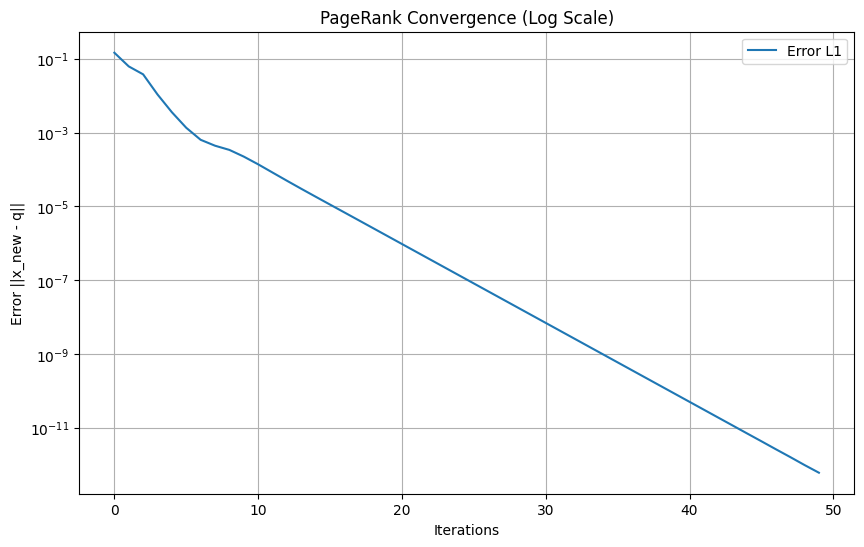

In [20]:
m = 0.15
print("\nExercise 14 Analysis:")
filename = "Graphs/exercise11_graph.dat"
A, _ = read_dat(filename)
n = A.shape[0]

# Calculate eigenvalues of M
S = np.ones((n, n)) / n
M = (1 - m) * A + m * S
eigvals, _ = np.linalg.eig(M)
lambda_2 = np.sort(np.abs(eigvals))[::-1][1]

print(f"Second Largest Eigenvalue |lambda_2|: {lambda_2:.6f}")
print(f"Expected Convergence Rate (1-m): {1-m:.6f}")

# True q
s_vec = np.ones(n) / n
q = power_iteration_with_vector(A, s_vec, m, tolerance=1e-14, max_iterations=2000)

# Random start
np.random.seed(42)
x_k = np.random.rand(n)
x_k = x_k / np.sum(x_k)

errors = []
for k in range(1, 51):
    x_new = (1 - m) * (A @ x_k) + m * s_vec
    x_new = x_new / np.sum(x_new)
    
    error = np.linalg.norm(x_new - q, 1)
    errors.append(error)
    x_k = x_new
    
plt.figure(figsize=(10, 6))
plt.semilogy(errors, label='Error L1')
plt.title('PageRank Convergence (Log Scale)')
plt.xlabel('Iterations')
plt.ylabel('Error ||x_new - q||')
plt.grid(True)
plt.legend()
plt.show()

The results confirm that the PageRank algorithm converges much faster than the pessimistic theoretical bound suggested by Proposition 4, effectively stabilizing at a rate determined by the second largest eigenvalue is equal to 0.61, which is well below the upper limit of 1-m = 0.85.


## Exercise 16: Non-Diagonalizability
**Problem statement:** Consider the link matrix  

$$
A =
\begin{bmatrix}
0 & \tfrac{1}{2} & \tfrac{1}{2} \\
0 & 0 & \tfrac{1}{2} \\
1 & \tfrac{1}{2} & 0
\end{bmatrix}.
$$

Show that  

$$
M = (1 - m)A + mS \qquad (\text{all } S_{ij} = \tfrac{1}{3})
$$

is not diagonalizable for $0 \le m < 1$.


We analyze the specific case of the provided graph.
1. **Eigenvalues of A:** $\lambda_{A} \in \{1, -1/2\}$.
2. **Eigenvalues of M:** $\lambda_1 = 1$ and $\lambda^* = -(1-m)/2$ (with algebraic multiplicity 2).
3. **Geometric Multiplicity:**
For $M$ to be diagonalizable, the geometric multiplicity (m.g.) of $\lambda^*$ must be 2.
Calculating $rank(\mathbf{M} - \lambda^* \mathbf{I})$, we find the rank is 2, thus m.g. is $3 - 2 = 1$.
Since $m.g. (1) < m.a. (2)$, the matrix is **NOT diagonalizable**.

## Exercise 17: Choice of m=0.15
**Problem statement:** How should the value of m be chosen? How does this choice affect the rankings and the computation time?

The choice of $m=0.15$ is a trade-off:
1. **Speed:** $|\lambda_2| \le 1-m$. If $m$ is large, convergence is very fast. If $m \to 0$, convergence slows down.
2. **Accuracy:** If $m$ is too large, the matrix becomes pure noise ($\mathbf{S}$) and the link structure is lost.
$m=0.15$ ensures fast convergence (factor approx 0.85) while maintaining the relevance of the hypertextual structure.